# Bayesian Optimization Example Using `mlos_core`

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [26]:
# Define a fake "performance" function.
# In an actual application, we would not have access to this function directly.
# Instead, we could only measure the outcome by running an experiment, such as timing
# a particular run of the system.
def f(x):
    return (6*x-2)**2*np.sin(12*x-4)

Text(0, 0.5, 'Objective (i.e. performance)')

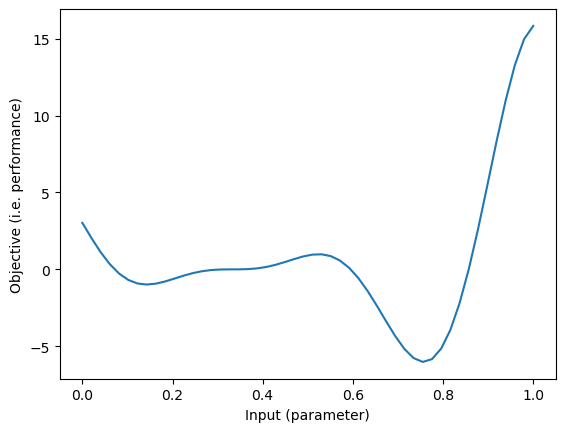

In [27]:
# define a domain to evaluate
line = np.linspace(0, 1)
# evaluate the function
values = f(line)
# plot the function
plt.plot(line, values)
plt.xlabel("Input (parameter)")
plt.ylabel("Objective (i.e. performance)")

In [28]:
import ConfigSpace as CS

# Start defining a ConfigurationSpace for the Optimizer to search.
input_space = CS.ConfigurationSpace(seed=1234)

# Add a single continuous input dimension between 0 and 1.
input_space.add_hyperparameter(CS.UniformFloatHyperparameter(name='x', lower=0, upper=1))

x, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5

In [29]:
import mlos_core.optimizers

In [30]:
# Choose an optimizer.

#optimizer = mlos_core.optimizers.RandomOptimizer(parameter_space=input_space)

#optimizer = mlos_core.optimizers.FlamlOptimizer(parameter_space=input_space)

optimizer = mlos_core.optimizers.SmacOptimizer(parameter_space=input_space) # , seed=42, n_random_init=20)

The argument budget is not set by SMAC: Consider removing it from the target function.
The argument instance is not set by SMAC: Consider removing it from the target function.


In [31]:
# Inspect the chosen optimizer
optimizer

SmacOptimizer(space_adapter=None)

Now, we can run the actual optimization which will carry out the steps outlined above.

In [32]:
def run_optimization(optimizer: mlos_core.optimizers.BaseOptimizer):
    # get a new config value suggestion to try from the optimizer.
    suggested_value, ctx = optimizer.suggest()
    
    # suggested value are dictionary-like, keys are input space parameter names
    # evaluate target function
    target_value = f(suggested_value['x'])
    print(suggested_value, "\n", target_value )
    print(ctx)
    optimizer.register(suggested_value, target_value, ctx)

# run for some iterations
n_iterations = 15
for i in range(n_iterations):
    run_optimization(optimizer)

          x
0  0.127704 
 0   -0.95008
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
          x
0  0.684865 
 0   -3.916802
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
          x
0  0.799596 
 0   -4.969943
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
          x
0  0.262942 
 0   -0.133384
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
          x
0  0.454756 
 0    0.527333
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
          x
0  0.982555 
 0    15.1432
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
          x
0  0.595362 
 0   -0.006794
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
          x
0  0.091976 
 0   -0.509295
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   N

After 15 iterations, the model is likely to have captured the general shape, but probably not have found the actual optimum since the first few iterations are spent randomly exploring the space.

In [33]:
optimizer.get_observations()

,x,score
0,0.127704,-0.950080
0,0.684865,-3.916802
0,0.799596,-4.969943
0,0.262942,-0.133384
0,0.454756,0.527333
0,0.982555,15.143200
0,0.595362,-0.006794
0,0.091976,-0.509295
0,0.006417,2.709667
0,0.555770,0.810420


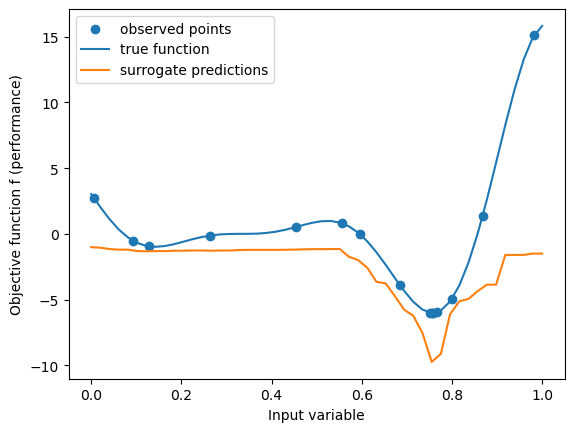

In [34]:
# evaluate the surrogate function
#
configs = pd.DataFrame(line.reshape(-1, 1), columns=['x'])
surrogate_predictions = optimizer.surrogate_predict(configs)

# plot the observations
#
observations = optimizer.get_observations()
plt.scatter(observations.x, observations.score, label='observed points')

# plot the true function (usually unknown)
#
plt.plot(line, values, label='true function')

# plot the surrogate
#
# alpha = optimizer_config.experiment_designer_config.confidence_bound_utility_function_config.alpha
# t_values = t.ppf(1 - alpha / 2.0, surrogate_predictions['predicted_value_degrees_of_freedom'])
# ci_radii = t_values * np.sqrt(surrogate_predictions['predicted_value_variance'])
# value = surrogate_predictions['predicted_value']
plt.plot(line, surrogate_predictions, label='surrogate predictions')
#plt.fill_between(line, value - ci_radii, value + ci_radii, alpha=.1)
#plt.plot(line, -optimizer.experiment_designer.utility_function(optimization_problem.construct_feature_dataframe(pd.DataFrame({'x': line}))), ':', label='utility_function')
plt.ylabel("Objective function f (performance)")
plt.xlabel("Input variable")
plt.legend()
plt.show()

We can find the best value according to the current surrogate with the ``optimum`` method:

In [35]:
optimizer.get_best_observation()

,x,score
0,0.757561,-6.020688


We can run more iterations to improve the surrogate model and the optimum that is found:

In [36]:
# run for more iterations
n_iterations = 50
for i in range(n_iterations):
    run_optimization(optimizer)

          x
0  0.758121 
 0   -6.020332
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
          x
0  0.757221 
 0   -6.02074
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
          x
0  0.756961 
 0   -6.020696
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
          x
0  0.303766 
 0   -0.010934
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
          x
0  0.757298 
 0   -6.020739
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
          x
0  0.757401 
 0   -6.020728
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
         x
0  0.75726 
 0   -6.02074
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None
1
          x
0  0.757247 
 0   -6.02074
Name: x, dtype: float64
  instance        seed budget
0     None  1847557174   None

There is some improvement in the optimum:

In [37]:
optimizer.get_best_observation()

,x,score
0,0.757247,-6.02074


We can now visualize the surrogate model and optimization process again. The points are colored according to the iteration number, with dark blue points being early in the process and yellow points being later. You can see that at the end of the optimization, the points start to cluster around the optimum.
The region to the right is not explored much because the surrogate model predicts that it is not likely to contain the optimum and hence also doesn't have as much accuracy compared to the real function there.

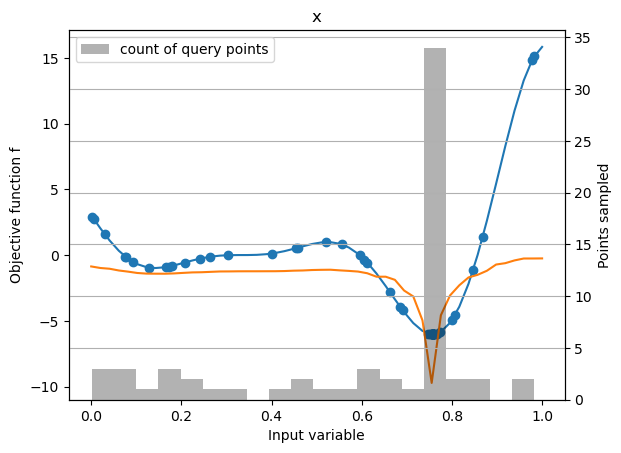

In [38]:
# evaluate the surrogate function
#
configs = pd.DataFrame(line.reshape(-1, 1), columns=['x'])
surrogate_predictions = optimizer.surrogate_predict(configs)

# plot the observations
#
observations = optimizer.get_observations()
plt.scatter(observations.x, observations.score, label='observed points')

# plot true function (usually unknown)
#
plt.plot(line, values, label='true function')

# plot the surrogate
#
#ci_raduii = surrogate_predictions['prediction_ci']
plt.plot(line, surrogate_predictions, label='surrogate predictions')
#plt.fill_between(line, value - ci_radii, value + ci_radii, alpha=.1)
#plt.plot(line, -optimizer.utility_function(pd.DataFrame({'x': line})), ':', label='utility_function')

ax = plt.gca()
ax.set_ylabel("Objective function f")
ax.set_xlabel("Input variable")
bins_axes = ax.twinx()
bins_axes.set_ylabel("Points sampled")
pd.DataFrame(observations.x).hist(bins=20, ax=bins_axes, alpha=.3, color='k', label="count of query points")
plt.legend()